# Exercise wiDeep Generative Autoencoder Model
Generative models are able to learn learn to represent a certain distribution of samples, such as images, and then then generate novel random samples indistinguishable from the original ones. The most typical generative models are Generative Adversarial Networks (GAN). Autoencoder models, on the other hand, can learn to encode new incoming images into a low-dimensional latent space. This representation can be used to manipulate the images in semantically meaningful ways, such as changing the shape of the nose or rotating the azimuth of the face. Typical autoencoders include variational autoencoders (VAE), denoising autoencoders and sparse autoencoders.

Recently, PIONEER networks (Progressively Growing Generative Autoencoders) [1] were introduced to combine the best of both worlds. They can both encode new input images for image editing purposes and generate completely novel random images.

For this exercise, we will be using pretrained PIONEER models on 128x128 resolution, trained with CelebA dataset which contains 202 000 images of celebrities, using the codebase [2].

[1] Heljakka, A., Solin, A., and Kannala, J. Pioneer networks: Progressively growing generative autoencoder. In Asian Conference on Computer Vision (ACCV), 2018.

[2] https://github.com/AaltoVision/pioneer

## Task 1. Load the model

Take a moment to make sure you are familiar with the concepts of autoencoders, generative models, and the use of a pre-trained machine learning model. Then run the following code as-is.

Note that loading the model with test_session_setup() may take a very long time, perhaps even 5 minutes. You can take the moment to consider the reason:
In a regular neural networks and deep learning setup, we would use a GPU to load and run the model. It would load up 10-100x faster, in a few seconds. In this environment, we use the CPU. Make sure you understand, on high level, why GPU is so much faster for these tasks. You can Google up the answer. For your own work, you can use any GPU in principle, e.g. gaming PCs. NVIDIA GPUs tend to have the best compatibility at the moment.

### Utility Code

In [1]:
import torch
import sys
sys.argv = ['no']

import numpy as np
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from pioneer import utils
#from src import sessions
from pioneer import config
from pioneer import train
from pioneer import data
from pioneer import evaluate

In [31]:
def test_session_setup(dataset_name, model_path, test_images_path, reso, load_checkpoint = -1):
    """load_checkpoint = The checkpoint to start from. -1 = load the newest. 0 = start from scratch.
    """
    global args
    args = config.get_config()
    args.data = dataset_name
    args.save_dir = model_path
    args.start_iteration = -1
    args.test_path = test_images_path
    args.testonly = True
    args.disable_cuda = False
    args.max_phase = int(np.log2(reso/4))
    args.no_TB = True
    
    train.setup()
        
    session = train.Session()
    session.create()
    test_data_loader = data.get_loader(args.data, args.test_path)
    
    evaluate.Utils.reconstruction_dryrun(session.g_running, session.encoder, test_data_loader, session=session)
    
    return session, test_data_loader

def get_data_iterator(session, loader, nr_of_images = 8, resolution = 64):
    return data.Utils.sample_data2(loader, min(nr_of_images, 16), resolution, session)

def encode(session, img):
    return session.encoder(img, session.phase, 1.0, False)

def decode(session, z):
    return session.generator(z, None, session.phase, 1.0)

%matplotlib inline
def show(img, figsize=(6,6)):
    npimg = img.numpy()
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1,2,0)) / 2 + 0.5, interpolation='bilinear')
    
def show_grid(imgs1):
    grid = (make_grid(imgs1[:], padding=5, nrow=5))
    show(grid,(12,12))

def show_pairs(imgs1, imgs2):
    t = torch.FloatTensor(imgs1.size(0) * 2, imgs1.size(1),
                          imgs1.size(2), imgs1.size(3))

    t[0::2] = imgs1[:]
    t[1::2] = imgs2[:]

    grid = (make_grid(t[:imgs1.size(0)*2] , padding=5, nrow=2)) #/ 2 + 0.5

    fig = plt.figure(figsize=(6,6))
    show(grid)
    
    return grid

def reconstruct(session, data_iterator):
    source_images, _ = next(data_iterator)
    with torch.no_grad():
        z = encode(session, source_images)
        dest_images = decode(session, z)
        show_pairs(source_images, dest_images)
        
def random_faces(session, random_id, num_imgs):
    import random
    random.seed(random_id)
    torch.manual_seed(random_id)
    torch.cuda.manual_seed_all(random_id)   
    
    from torch.autograd import Variable
    with torch.no_grad():
        myz = Variable(torch.randn(num_imgs, 512))#.cuda()
        myz = utils.normalize(myz)
        myz, input_class = utils.split_labels_out_of_latent(myz)
    
        new_imgs = session.generator(
            myz,
            input_class,
            session.phase,
            1.0).detach().data.cpu()
    return new_imgs

Note: You may see some deprecation warnings when running the below code. They are harmless.

In [3]:
session128, test_data_loader128 = test_session_setup(
            dataset_name = 'celeba',
            model_path = './celeba128',
            test_images_path = './test_128_in',
            reso = 128
    )

In test mode, sample mirroring is disabled automatically.
Namespace(KL='qp', aux_outpath=None, checkpoint_cycle=10000, data='celeba', device=device(type='cuda'), disable_cuda=False, dump_trainingset_N=0, dump_trainingset_dir='.', fake_D_KL_scale=0.1, fake_G_KL_scale=0.1, force_alpha=-1.0, gpu_count=1, h5=False, images_per_stage=2400000.0, interpolate_N=0, load_SNU=True, lr=0.001, manual_seed=123, match_x=1, match_x_metric='L1', match_z=100, match_z_metric='cos', matching_phase_x=1.5, max_phase=5, n_critic=1, n_generator=2, n_label=1, nc=3, no_TB=True, no_load_SNU=False, no_progression=False, noise='sphere', nz=511, phase_offset=0, real_x_KL_scale=0.1, reconstructions_N=0, reset_optimizers=0, resize_training_data=True, run_mode=1, sample_N=128, sample_dir=None, sample_mirroring=False, save_dir='./celeba128', start_iteration=-1, start_phase=0, step_offset=0, summary_dir='log/pine/runs', test_path='./test_128_in', testonly=True, total_kimg=16800, train_mode=1, train_path=None, use_ALQ=0, 

C:\Users\arihe\git\pioneer\pioneer\model.py:124: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(conv.weight)


Using  1  GPUs!
Session created.
./celeba128/checkpoint/36200000_state
Reloaded old optimizers
Loaded ./celeba128/checkpoint/36200000_state
Iteration asked 36200000 and got 36200000
Warning! No SNU found.
Warm-up rounds: 10


C:\Users\arihe\Miniconda3\lib\site-packages\torch\nn\functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


## Task 2. Generate random faces from the model with your student ID

A proper generative model can generate a completely fabricated sample based on a random (noise) vector.
In this case, your student ID serves as the *random seed* for the noise vector. The vector itself is a 512-dimensional random vector.
Often these vectors are generated from Gaussian (aka "normal") distribution, due to their nice theoretical properties. Here, they will also get (behind the scenes) normalized to unit length. Try generating the random faces below. Note: The images are 128x128, so if they look pixelated, please pay attention to your screen resolution, since your browser may stretch them.

Sometimes the images will look so realistic that you might think the model is cheating somehow. We will soon show a way to ensure that this is not the case. Sometimes, though, the images will be completely broken in various but often interesting ways. You can experiment with replacing the student_id with any integer and see what happens.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


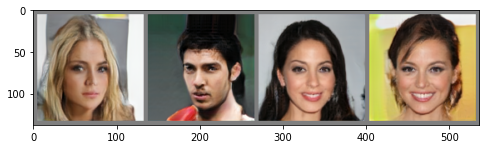

In [7]:
student_id = 123 # <= Insert your student ID here (numbers only)
imgs = random_faces(session128, student_id, 4)
show_grid(imgs)

## Task 3. Reconstruct a face image.
Autoencoders have the capability to encode an input sample (here, a face) into a very compact internal representation called 'latent code'.
This is similar to compressing an image very tightly.
The latent code can then be decoded back into an image, which we would like to resemble the original image as much as possible.
Take a moment to consider why we do this. What would be the benefit of having the latent code? What could we do with it?
Below, you load in some images from the test dataset and ask the model to encode them into latent space, and then decode back to the image space.
The images on the left are originals and the ones on the right are reconstructions.

In [25]:
it128 = get_data_iterator(session128, test_data_loader128, 2, 128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x432 with 0 Axes>

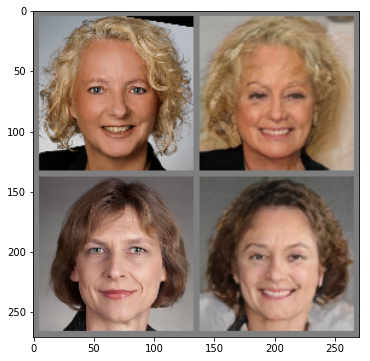

In [22]:
reconstruct(session128, it128)

## Task 4. Interpolate between 2 faces.
Consider taking two images as input. The autoencoder creates a latent code for both. Now, these codes are just 512-dimensional vectors. What happens if we change them slightly? What happens if we take the vector that is exactly between them?
Try it out below! First, we encode the images into the latent code 'z'.

In [26]:
#test_data_loader128 = data.get_loader(args.data, args.test_path)
#it128 = get_data_iterator(session128, test_data_loader128, 2, 128)

source_images, _ = next(it128)
with torch.no_grad():
    z = encode(session128, source_images)
np.shape(z)

torch.Size([2, 512])

Next, we take the latent codes of the 2 reconstructed images, and find out the vector that is exactly in the middle of them:

In [27]:
z_mid = (torch.FloatTensor(3, z[0].size(0)))

z_mid[0] = z[0]
z_mid[2] = z[1]
z_mid[1] = z[0] + (z[1] - z[0])/2
with torch.no_grad():
    imgs = decode(session128, z_mid)

In [28]:
imgs2 = (torch.FloatTensor(5, 3,128,128))
imgs2[1:4,:,:,:] = imgs
imgs2[0,:,:,:] = source_images[0]
imgs2[4,:,:,:] = source_images[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


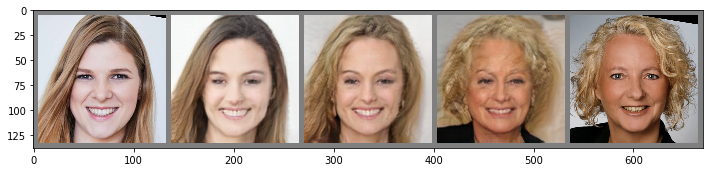

In [32]:
show_grid(imgs2)

Hold on. Why do we need to do this? We could just take the average between the pixels of the two images, right?
Yes, we can. We try this below. But depending on which samples you see, it often fails. Can you explain why?

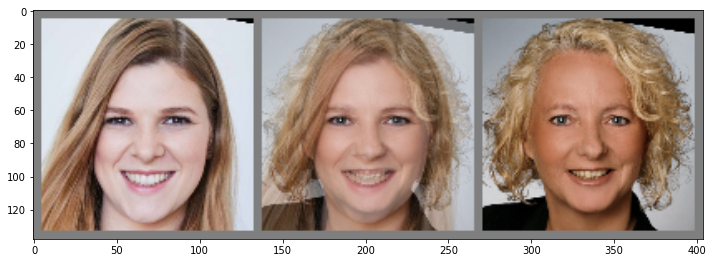

In [33]:
imgs3 = (torch.FloatTensor(3, 3,128,128))
imgs3[0,:,:,:] = source_images[0]
imgs3[1,:,:,:] = (source_images[0] + source_images[1]) / 2
imgs3[2,:,:,:] = source_images[1]
show_grid(imgs3)

## OPTIONAL task 5.
Now you may have an idea of why the latent codes are so useful. We can modify images on a more abstract level by modifying the code. But instead of just taking the middle point between two faces, we can actually take any points between them, and decode them back to image space, as long as they are strictly along the vector that connects the two codes.

In task #4 we just took the middle point between the two vectors.
Try writing the code that produces 5 intermediate points between the two vectors, with evenly spaced intervals (e.g. in 1-dimension, if your latent codes are 2 and 5, you would generate the intermediate points 2.5, 3.0, 3.5, 4, and 4.5).
Then, decode these back to the image space.
You should see smooth transition from one image to the next.


## Optional task 6.
Find your own face images at 128x128 resolution and align the images as exactly as possible to resemble the test images given here. (The resolution must be exact and they eye positions must align as well as possible.)
Upload the aligned images to the Jupyter environment.
Run the reconstructions and interpolations for your own images.
Does the reconstruction look good? If not, consider why this could be the case. Note that the model has been trained with a dataset that has many more female than male faces, so it often reconstructs male faces as female.